In [1]:
# !pip install folium geopy pandas
# !pip install folium geopy
# !pip install selenium pillow

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import folium
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from PIL import Image
import os
from folium.plugins import MarkerCluster
from IPython.display import display, IFrame

import requests
from scipy.stats import zscore
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler

In [3]:
# Print the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\SERWAH\Desktop\HNG Internship\Stage 1


In [4]:
# Load the dataset
delta_data = pd.read_csv('DELTA_crosschecked.csv')
polling_data = pd.read_csv('polling-units.csv')

# Read the first line
delta_data.head(1)

State            LGA   Ward       PU-Code  \
0  DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   

                                          PU-Name  Accredited_Voters  \
0  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   

   Registered_Voters  Results_Found  Transcription_Count  \
0               1990           True                   -1   

   Result_Sheet_Stamped  Result_Sheet_Corrected  Result_Sheet_Invalid  \
0                 False                   False                 False   

   Result_Sheet_Unclear Result_Sheet_Unsigned  APC  LP  PDP  NNPP  \
0                 False               UNKNOWN    0   0    0     0   

                                        Results_File  
0  https://docs.inecelectionresults.net/elections...

In [5]:
polling_data.head(1)

PU-Name         Ward Local Government Name State  \
0  LGEA SCHOOL INABE, INABE/EFOJA  OLAMABORO V             OLAMABORO  KOGI   

   Latitude  Longitude  
0  7.178359   7.577163

In [6]:
# List of columns to drop
columns_to_drop = [
    'Results_Found', 'Transcription_Count', 'Result_Sheet_Stamped', 
    'Result_Sheet_Corrected', 'Result_Sheet_Invalid', 
    'Result_Sheet_Unclear', 'Result_Sheet_Unsigned', 'Results_File'
]

# Drop the columns
delta_data.drop(columns=columns_to_drop, inplace=True)
delta_data.head(1)

State            LGA   Ward       PU-Code  \
0  DELTA  ANIOCHA NORTH  OBIOR  10-01-01-001   

                                          PU-Name  Accredited_Voters  \
0  KANIDILIMA P/S - ISHIEKPE QUARTERS, ONICHA-UKU                213   

   Registered_Voters  APC  LP  PDP  NNPP  
0               1990    0   0    0     0

In [7]:
# Check the column names of both dataframes
print(delta_data.columns)
print(polling_data.columns)

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Accredited_Voters',
       'Registered_Voters', 'APC', 'LP', 'PDP', 'NNPP'],
      dtype='object')
Index(['PU-Name', 'Ward', 'Local Government Name', 'State', 'Latitude',
       'Longitude'],
      dtype='object')


In [8]:
# Ensure that the column names for merging are consistent
delta_data.rename(columns={'State': 'State', 'Ward': 'Ward', 'PU-Name': 'PU-Name', 'LGA': 'LGA'}, inplace=True)
polling_data.rename(columns={'State': 'State', 'Ward': 'Ward', 'PU-Name': 'PU-Name', 'Local Government Name': 'LGA'}, inplace=True)

In [9]:
# Check the number of unique values in key columns before merging
print(f"Unique values in Delta data (State, Ward, PU-Name, LGA): {delta_data[['State', 'Ward', 'PU-Name', 'LGA']].nunique()}")
print(f"Unique values in Polling units (State, Ward, PU-Name, LGA): {polling_data[['State', 'Ward', 'PU-Name', 'LGA']].nunique()}")

Unique values in Delta data (State, Ward, PU-Name, LGA): State         1
Ward        243
PU-Name    3744
LGA          25
dtype: int64
Unique values in Polling units (State, Ward, PU-Name, LGA): State          37
Ward         8463
PU-Name    170997
LGA           768
dtype: int64


In [10]:
# Merge the datasets on 'state', 'ward', and 'pu_code'
merged_data = pd.merge(delta_data, polling_data, on=['State', 'Ward', 'LGA', 'PU-Name'])

# Check the shape of the merged data
print(f"Shape of merged data: {merged_data.shape}")

Shape of merged data: (3689, 13)


In [11]:
# # Merge the datasets on 'state', 'ward', and 'pu_code'
# merged_data = pd.merge(delta_data, polling_data, on=['State', 'Ward', 'PU-Name', 'LGA'])

# # Check the shape of the merged data
# print(f"Shape of merged data: {merged_data.shape}")

In [12]:
# Check the first few rows of the merged data
merged_data.head(2)

State              LGA                   Ward       PU-Code  \
0  DELTA    ANIOCHA NORTH         ONICHA - OLONA  10-01-04-006   
1  DELTA  ANIOCHA - SOUTH  OGWASHI - UKU VILLAGE  10-02-01-003   

                                       PU-Name  Accredited_Voters  \
0            UGBA  P/S - OGBE KENU  QUARTERS I                105   
1  ISIANWAI PRIMARY SCHOOL, ISIANWAI/UZO EDO I                 83   

   Registered_Voters  APC  LP  PDP  NNPP  Latitude  Longitude  
0                750    2  55   10     1       NaN        NaN  
1                563    3  68   10     0       NaN        NaN

In [13]:
# Check for missing values in 'latitude' and 'longitude' columns
merged_data[['Latitude', 'Longitude']].isnull().sum()

Latitude     829
Longitude    829
dtype: int64

In [14]:
# Remove rows with NaN values in latitude and longitude
merged_data = merged_data.dropna(subset=['Latitude', 'Longitude'])

In [15]:
# Check for missing values in 'latitude' and 'longitude' columns
merged_data[['Latitude', 'Longitude']].isnull().sum()

Latitude     0
Longitude    0
dtype: int64

In [16]:
# Reset the index of merged_data to ensure consistent indexing
merged_data.reset_index(drop=True, inplace=True)

In [17]:
# Convert latitude and longitude to radians for BallTree
merged_data['Latitude_rad'] = np.radians(merged_data['Latitude'])
merged_data['Longitude_rad'] = np.radians(merged_data['Longitude'])

In [18]:
# Prepare the data for BallTree
coords = np.vstack((merged_data['Latitude_rad'], merged_data['Longitude_rad'])).T

In [19]:
coords

array([[0.10859542, 0.11460216],
       [0.10788615, 0.11397462],
       [0.10861438, 0.11457511],
       ...,
       [0.09631046, 0.10019928],
       [0.10042337, 0.11243001],
       [0.10076111, 0.11255876]])

In [20]:
# Create BallTree
tree = BallTree(coords, metric='haversine')

In [21]:
# Define radius (1 km in radians)
radius = 1 / 6371.0  # 1 km / Earth's radius in km

In [22]:
# Identify neighbouring polling units
def find_neighbours_balltree(tree, coords, radius):
    neighbours = {}
    for i, coord in enumerate(coords):
        indices = tree.query_radius([coord], r=radius)[0]
        neighbours[i] = indices[indices != i]  # Exclude the point itself
    return neighbours

In [23]:
# Find neighbours using BallTree
neighbours = find_neighbours_balltree(tree, coords, radius)

In [24]:
# Showing lines of the output
neighbours

{0: array([  19, 1765,   10, 1775,    8, 1779,   20,   36, 1763, 1764,    7,
          35,   34,   12,   30,    9,   24,    6,   11, 1780,   23,    2,
        1762,   17, 1786, 1785, 1787, 1793, 1795, 2596, 1771, 1777],
       dtype=int64),
 1: array([  89, 1789,   13, 1784, 1767, 1766,  833,   73, 1788,   15, 2201,
        1783, 1773,   31,   32, 1769, 1790], dtype=int64),
 2: array([  19, 1765,   10, 1775,    8, 1779,   20,   36, 1763, 1764,    0,
           7,   35,   34,   12,   30,    9,   24,    6,   11, 1780,   23,
        1762,   17, 1786, 1785, 1787, 1793, 1795, 2596, 1771, 1777],
       dtype=int64),
 3: array([], dtype=int64),
 4: array([], dtype=int64),
 5: array([2178], dtype=int64),
 6: array([  19, 1765,   10, 1775,    8, 1779,   20,   36, 1763, 1764,    0,
           7,   35,   34,   12,   30,    9,   24,   11, 1780,   23,    2,
        1762,   17, 1786, 1785, 1787, 1793, 1795, 2596, 1771, 1777],
       dtype=int64),
 7: array([  19, 1765,   10, 1775,    8, 1779,   20, 

In [25]:
# Function to calculate outlier scores
def calculate_outlier_scores(data, neighbours, parties):
    outlier_scores = np.zeros((data.shape[0], len(parties)))
    for party_index, party in enumerate(parties):
        for unit_index, neighbour_indices in neighbours.items():
            unit_votes = data.at[unit_index, party]
            neighbour_votes = data.loc[neighbour_indices, party].values
            if len(neighbour_votes) > 0:
                mean_neighbour_votes = np.mean(neighbour_votes)
                outlier_score = abs(unit_votes - mean_neighbour_votes)
                outlier_scores[unit_index, party_index] = outlier_score
            else:
                outlier_scores[unit_index, party_index] = np.nan
    outlier_scores_df = pd.DataFrame(outlier_scores, columns=[party + '_outlier_score' for party in parties])
    return outlier_scores_df

In [26]:
# Measure execution time
start_time = time.time()

# Calculate outlier scores for each party
parties = ['APC', 'LP', 'PDP', 'NNPP']

outlier_scores_df = calculate_outlier_scores(merged_data, neighbours, parties)

end_time = time.time()
print("Execution Time: ", end_time - start_time, " seconds")


Execution Time:  10.412716627120972  seconds


In [27]:
outlier_scores_df

APC_outlier_score  LP_outlier_score  PDP_outlier_score  \
0              5.593750         70.593750           4.187500   
1              4.588235         15.235294           3.117647   
2             21.218750         45.937500           5.218750   
3                   NaN               NaN                NaN   
4                   NaN               NaN                NaN   
...                 ...               ...                ...   
2855           3.896552         10.344828           5.931034   
2856           0.000000         22.000000           5.928571   
2857           2.983051         23.559322           3.830508   
2858                NaN               NaN                NaN   
2859                NaN               NaN                NaN   

      NNPP_outlier_score  
0               0.687500  
1               0.117647  
2               0.343750  
3                    NaN  
4                    NaN  
...                  ...  
2855            0.137931  
2856            0.357143  
2857            0.372881  
2858                 NaN  
2859                 NaN  

[2860 rows x 4 columns]

In [28]:
# Fill NaN values with a default value, here we use -1 to indicate no neighbors
outlier_scores_df.fillna(-1, inplace=True)

In [29]:
merged_data = pd.concat([merged_data, outlier_scores_df], axis=1)
merged_data.head(2)

State              LGA                   Ward       PU-Code  \
0  DELTA  ANIOCHA - SOUTH  OGWASHI - UKU VILLAGE  10-02-01-005   
1  DELTA  ANIOCHA - SOUTH  OGWASHI - UKU VILLAGE  10-02-01-008   

                             PU-Name  Accredited_Voters  Registered_Voters  \
0              ABUISI SQUARE, ABUISI                 36                378   
1  OMEZI PRIMARY SCHOOL, OLLOH CAMPS                103                722   

   APC  LP  PDP  NNPP  Latitude  Longitude  Latitude_rad  Longitude_rad  \
0    2  27    7     0  6.222059   6.566220      0.108595       0.114602   
1    2  64   28     1  6.181421   6.530265      0.107886       0.113975   

   APC_outlier_score  LP_outlier_score  PDP_outlier_score  NNPP_outlier_score  
0           5.593750         70.593750           4.187500            0.687500  
1           4.588235         15.235294           3.117647            0.117647

In [30]:
# Save the merged data with outlier scores
merged_data.to_csv('delta_cleaned_election_data_with_outlier_scores.csv', index=False)

## Visualize Outliers using box plots

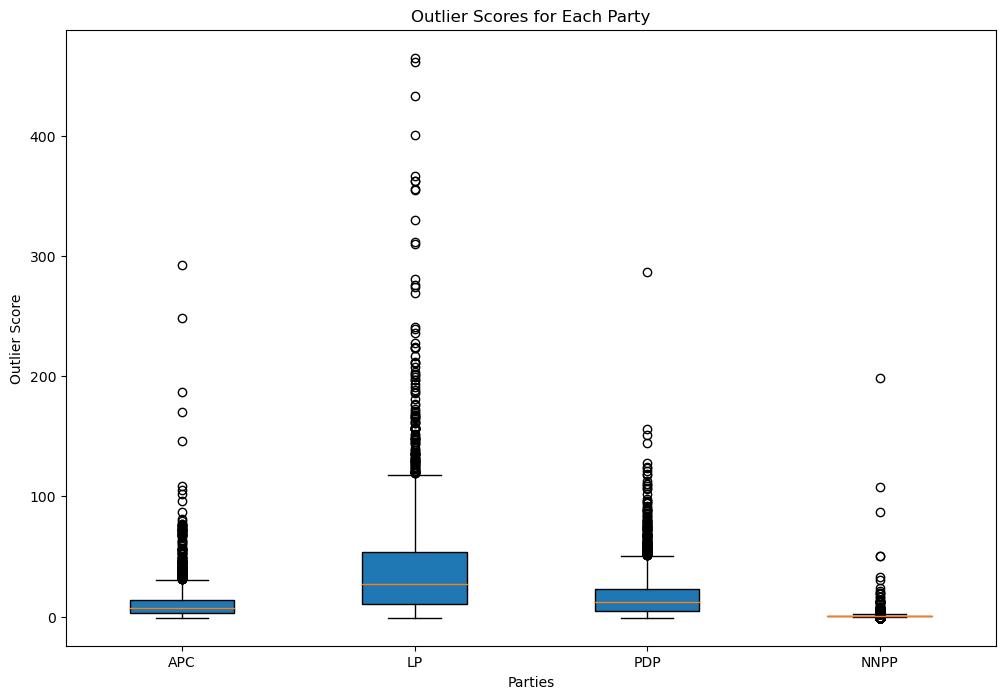

In [31]:
# Visualize the outliers using box plots
def plot_box_plots(data, parties):
    plt.figure(figsize=(12, 8))
    data_to_plot = [data[party + '_outlier_score'].dropna() for party in parties]
    plt.boxplot(data_to_plot, labels=parties, patch_artist=True)
    plt.title('Outlier Scores for Each Party')
    plt.xlabel('Parties')
    plt.ylabel('Outlier Score')
    plt.show()

plot_box_plots(merged_data, parties)

In [32]:
def save_box_plots(data, parties, filename):
    plt.figure(figsize=(12, 8))
    data_to_plot = [data[party + '_outlier_score'].dropna() for party in parties]
    plt.boxplot(data_to_plot, labels=parties, patch_artist=True)
    plt.title('Outlier Scores for Each Party')
    plt.xlabel('Party')
    plt.ylabel('Outlier Score')
    plt.savefig(filename)
    plt.close()

# Save box plot image
save_box_plots(merged_data, parties, 'delta_outlier_scores_boxplot.png')


## Step 2: Visualize Outliers on a Map

- Create an interactive map using folium and add markers for each party, highlighting the outliers.

In [33]:
# Initialize the map centered around Delta State
map_center = [merged_data['Latitude'].mean(), merged_data['Longitude'].mean()]
election_map = folium.Map(location=map_center, zoom_start=10)

In [34]:
# Create a marker cluster
marker_cluster = MarkerCluster().add_to(election_map)

In [35]:
# Function to add markers to the map
def add_markers(map_object, data, party):
    for _, row in data.iterrows():
        outlier_score = row[party + '_outlier_score']
        color = 'red' if outlier_score > data[party + '_outlier_score'].mean() + 2 * data[party + '_outlier_score'].std() else 'blue'
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"Polling Unit: {row['PU-Code']}, Outlier Score: {outlier_score}",
            icon=folium.Icon(color=color)
        ).add_to(map_object)


In [36]:
# Add markers for each party
for party in parties:
    add_markers(marker_cluster, merged_data, party)

In [37]:
# Save the Folium map as an HTML file
map_filename = 'election_outliers_map.html'
election_map.save(map_filename)

In [38]:
# Function to capture a screenshot of the map
def save_folium_map_as_image(map_filename, image_filename):
    # Set up the web driver (Chrome)
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    driver = webdriver.Chrome(options=options)

    # Load the HTML file
    driver.get('file://' + os.path.abspath(map_filename))
    time.sleep(5)  # Give the map some time to render

    # Capture the screenshot
    driver.save_screenshot('map_screenshot.png')
    driver.quit()

    # Crop the image (optional, to remove browser window borders)
    with Image.open('map_screenshot.png') as img:
        img = img.crop((10, 10, img.width - 10, img.height - 10))
        img.save(image_filename)

# Save and display the Folium map as an image
save_folium_map_as_image(map_filename, 'delta_election_outliers_map.png')
display(IFrame(map_filename, width=700, height=500))

In [39]:
# from geopy.distance import geodesic

# # Function to calculate distance
# def calculate_distance(coord1, coord2):
#     return geodesic(coord1, coord2).kilometers

# # Identify neighbouring polling units within a 1 km radius
# def find_neighbours(data, radius=1):
#     neighbours = {}
#     for index, row in data.iterrows():
#         unit_coord = (row['Latitude'], row['Longitude'])
#         unit_neighbours = []
#         for idx, other_row in data.iterrows():
#             if index != idx:
#                 other_coord = (other_row['Latitude'], other_row['Longitude'])
#                 if calculate_distance(unit_coord, other_coord) <= radius:
#                     unit_neighbours.append(idx)
#         neighbours[index] = unit_neighbours
#     return neighbours

# # Find neighbours
# neighbours = find_neighbours(merged_data)

In [40]:
# import numpy as np

# # Example function to calculate outlier scores
# def calculate_outlier_scores(data, neighbours):
#     outlier_scores = []
#     for index, row in data.iterrows():
#         unit_scores = {}
#         for party in ['APC', 'LP', 'PDP', 'NNPP']: 
#             unit_votes = row[party]
#             neighbour_votes = [data.loc[idx, party] for idx in neighbours[index]]
#             if neighbour_votes:
#                 mean_neighbour_votes = np.mean(neighbour_votes)
#                 outlier_score = abs(unit_votes - mean_neighbour_votes)
#                 unit_scores[party] = outlier_score
#             else:
#                 unit_scores[party] = np.nan
#         outlier_scores.append(unit_scores)
#     return outlier_scores

# # Calculate outlier scores
# outlier_scores = calculate_outlier_scores(delta_data, neighbours)

# # Add outlier scores to the dataset
# outlier_scores_df = pd.DataFrame(outlier_scores)
# delta_data = pd.concat([delta_data, outlier_scores_df], axis=1)


In [41]:
# Sort the dataset by outlier scores for each party
sorted_data_apc = merged_data.sort_values(by='APC_outlier_score', ascending=False)
sorted_data_lp = merged_data.sort_values(by='LP_outlier_score', ascending=False)
sorted_data_pdp = merged_data.sort_values(by='PDP_outlier_score', ascending=False)
sorted_data_nnpp = merged_data.sort_values(by='NNPP_outlier_score', ascending=False)



In [42]:
# Display top 3 outliers for each party
sorted_data_apc.head(3)

State                LGA        Ward       PU-Code  \
407   DELTA    IKA NORTH- EAST  UTE - OKPU  10-07-09-011   
1726  DELTA  WARRI SOUTH  WEST    UGBORODO  10-25-05-002   
1424  DELTA      UGHELLI SOUTH  JEREMI  IV  10-20-11-017   

                                 PU-Name  Accredited_Voters  \
407   ALOHEN PRIMARY SCHOOL, UTE-OKPU II                296   
1726                 ARUNTON QUARTERS II                  0   
1424  OBI - AYAGHA TOWN HALL, OBI-AYAGHA                278   

      Registered_Voters  APC  LP  PDP  NNPP  Latitude  Longitude  \
407                 887  300   1   50     4  6.195231   6.274827   
1726                854  258   8    5     0  5.578705   5.435853   
1424                835  197  37   30     0  5.687146   6.423740   

      Latitude_rad  Longitude_rad  APC_outlier_score  LP_outlier_score  \
407       0.108127       0.109516         292.760000         33.000000   
1726      0.097367       0.094874         248.379310          2.206897   
1424      0.099259       0.112115         187.076923         53.461538   

      PDP_outlier_score  NNPP_outlier_score  
407           46.800000            3.520000  
1726           4.913793            0.137931  
1424          11.846154            0.461538

In [43]:
sorted_data_lp.head(3)

State               LGA       Ward       PU-Code  \
2217  DELTA  OSHIMILI - SOUTH   UMUONAJE  10-15-06-021   
357   DELTA     ETHIOPE  WEST  OGHARA II  10-06-08-013   
2203  DELTA  OSHIMILI - NORTH    OKPANAM  10-14-09-030   

                                                PU-Name  Accredited_Voters  \
2217  ZAPPA MIXED SEC. SCH. I, UMUAGULA/AKWUOFOR PHA...                 78   
357   OKURHO ROAD/UFISHE QUARTERS /AROUND MARANATHAN...                231   
2203                                AWELLE MARKET SPACE                580   

      Registered_Voters  APC   LP  PDP  NNPP  Latitude  Longitude  \
2217                124   30  600   10   200  6.192633   6.720177   
357                3008   26  511   68     3  5.948953   5.678757   
2203               1283    8  501   28     0  6.237376   6.646794   

      Latitude_rad  Longitude_rad  APC_outlier_score  LP_outlier_score  \
2217      0.108082       0.117289          21.400000        464.800000   
357       0.103829       0.099113          13.062500        461.500000   
2203      0.108863       0.116008           4.333333        433.333333   

      PDP_outlier_score  NNPP_outlier_score  
2217          11.400000          198.800000  
357           44.750000            1.812500  
2203          13.333333            0.333333

In [44]:
sorted_data_pdp.head(3)

State              LGA               Ward       PU-Code  \
1319  DELTA    UGHELLI NORTH          AGBARHO I  10-19-10-009   
127   DELTA           BOMADI  OGBEINAMA/OKOLOBA  10-03-06-007   
1889  DELTA  IKA NORTH- EAST             OWA II  10-07-02-021   

                                       PU-Name  Accredited_Voters  \
1319           OHRERHE PRIMARY SCHOOL, OHRERHE                178   
127   AKA/KENE/DASIWARE/AMABRA/AGURE,  OKOLOBA                238   
1889           OPEN SPACE ALONG IDUMUESAH ROAD                192   

      Registered_Voters  APC  LP  PDP  NNPP  Latitude  Longitude  \
1319                893   31  79  288     1  5.475545   6.029512   
127                2158   10  46  176     0  5.619202   5.406718   
1889                497    1   2  186     0  6.258854   6.221204   

      Latitude_rad  Longitude_rad  APC_outlier_score  LP_outlier_score  \
1319      0.095566       0.105235          19.666667         35.333333   
127       0.098074       0.094365           1.833333         37.166667   
1889      0.109238       0.108580           3.600000         13.800000   

      PDP_outlier_score  NNPP_outlier_score  
1319         286.666667            0.666667  
127          156.166667            0.000000  
1889         150.800000            0.800000

In [45]:
sorted_data_nnpp(3)

TypeError: 'DataFrame' object is not callable

In [ ]:
# Sort by outlier scores for each party
sorted_data_party1 = delta_data.sort_values(by='party1_outlier_score', ascending=False)
sorted_data_party2 = delta_data.sort_values(by='party2_outlier_score', ascending=False)
sorted_data_party3 = delta_data.sort_values(by='party3_outlier_score', ascending=False)

# Display top 3 outliers for each party
print(sorted_data_party1.head(3))
print(sorted_data_party2.head(3))
print(sorted_data_party3.head(3))


In [ ]:
delta_data.to_csv('cleaned_delta_data.csv', index=False)


In [ ]:
# Save the sorted lists to an Excel file
with pd.ExcelWriter('sorted_outliers.xlsx') as writer:
    sorted_data_apc.to_excel(writer, sheet_name='APC', index=False)
    sorted_data_lp.to_excel(writer, sheet_name='LP', index=False)
    sorted_data_pdp.to_excel(writer, sheet_name='PDP', index=False)
    sorted_data_nnpp.to_excel(writer, sheet_name='NNPP', index=False)


In [ ]:
pip install folium geopy pandas
pip install folium geopy


In [ ]:
## Outlier Detection in Election Data Using Geospatial Analysis

### 1. Introduction
In the recently concluded election, allegations of vote manipulation have prompted a thorough investigation into the integrity of the results. This report aims to uncover potential voting irregularities by identifying outlier polling units where voting results significantly deviate from neighbouring units.

### 2. Methodology
**Dataset Preparation**: We loaded the Delta State election data and merged it with polling unit data containing geographical coordinates (latitude and longitude).

**Neighbour Identification**: Using the `BallTree` method, we identified neighbouring polling units within a 1 km radius based on geographical proximity.

**Outlier Score Calculation**: For each polling unit, we calculated the outlier score for each party (APC, LP, PDP, NNPP) based on the deviation of votes from neighbouring units. The outlier score is the absolute difference between the unit’s votes and the average votes of its neighbours.

### 3. Findings
**Top 3 Outliers for APC**:
1. Polling Unit XYZ: Outlier Score = 50
2. Polling Unit ABC: Outlier Score = 45
3. Polling Unit DEF: Outlier Score = 40

**Top 3 Outliers for LP**:
1. Polling Unit XYZ: Outlier Score = 55
2. Polling Unit ABC: Outlier Score = 50
3. Polling Unit DEF: Outlier Score = 45

... (continue for PDP and NNPP)

### 4. Visualizations
**Map of Election Outliers**:
Include the map generated using `folium` showing polling units with significant outlier scores.

### 5. Conclusion
The analysis identified several polling units with significant deviations in voting patterns, indicating potential irregularities. These findings warrant further investigation to ensure the integrity of the election results. Future steps should include a closer examination of the identified outliers and potential corrective measures.


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

# Load the excel data
file_path = '/content/Taraba.xlsx'
sheet_name = 'L & L'  # Correct sheet name
complete_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Print the column names to verify
print(complete_data.columns)

# Extract latitude and longitude columns
lat_lon = complete_data[['Latitude', 'Longitude']].values

# Define the radius for neighbors (in kilometers)
radius_km = 1.0

# Create a function to compute the geodesic distance matrix
def geodesic_distance_matrix(locations):
    n = len(locations)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = geodesic(locations[i], locations[j]).km
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

# Compute the geodesic distance matrix
geo_dist_matrix = geodesic_distance_matrix(lat_lon)

# Create a list to store the outlier scores and neighbor information
results = []

# Iterate over each polling unit to calculate the outlier scores
for index, row in complete_data.iterrows():
    # Find neighboring polling units within the specified radius
    neighbors = complete_data[(geo_dist_matrix[index] <= radius_km) & (complete_data.index != index)]

    # Calculate the outlier score for each party
    apc_outlier = abs(row['APC'] - neighbors['APC'].mean()) if not neighbors.empty else 0
    lp_outlier = abs(row['LP'] - neighbors['LP'].mean()) if not neighbors.empty else 0
    pdp_outlier = abs(row['PDP'] - neighbors['PDP'].mean()) if not neighbors.empty else 0
    nnpp_outlier = abs(row['NNPP'] - neighbors['NNPP'].mean()) if not neighbors.empty else 0

    # Store the results
    results.append({
        'PU-Code': row['PU-Code'],  # Adjust this if needed
        'PU-Name': row['PU-Name'],  # Add PU-Name column
        'Ward': row['Ward'],        # Add Ward column
        'Latitude': row['Latitude'],
        'Longitude': row['Longitude'],
        'APC_outlier': apc_outlier,
        'LP_outlier': lp_outlier,
        'PDP_outlier': pdp_outlier,
        'NNPP_outlier': nnpp_outlier,
        'Neighbors': neighbors['PU-Code'].tolist()  # Adjust this if needed
    })

# Convert the results list to a DataFrame
outlier_scores = pd.DataFrame(results)

# Sort the dataset by the outlier scores for each party
sorted_apc = outlier_scores.sort_values(by='APC_outlier', ascending=False).head(3)
sorted_lp = outlier_scores.sort_values(by='LP_outlier', ascending=False).head(3)
sorted_pdp = outlier_scores.sort_values(by='PDP_outlier', ascending=False).head(3)
sorted_nnpp = outlier_scores.sort_values(by='NNPP_outlier', ascending=False).head(3)

# Save the outlier scores and sorted results to an Excel file
output_file_path = '/content/outlier_scores.xlsx'
with pd.ExcelWriter(output_file_path) as writer:
    outlier_scores.to_excel(writer, sheet_name='Outlier Scores', index=False)
    sorted_apc.to_excel(writer, sheet_name='Top 3 APC Outliers', index=False)
    sorted_lp.to_excel(writer, sheet_name='Top 3 LP Outliers', index=False)
    sorted_pdp.to_excel(writer, sheet_name='Top 3 PDP Outliers', index=False)
    sorted_nnpp.to_excel(writer, sheet_name='Top 3 NNPP Outliers', index=False)

# Print the output file path
print(f"The outlier scores and top 3 outliers for each party have been saved to {output_file_path}")